In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import time

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [49]:
r_min = 1e-3
r_max = 1.0

M = 10 # numero de modelos que se entrenan es secuencia
N = 100

l=0 #numero cuantico l

lr = 1e-3
layers = 2
neuronas = 20
epocs = 7_000

In [50]:
# funcion de activacion para todas las capas

class FunAct(nn.Module):
    def forward(self,r):
        return torch.sin(r)

# modelo para la red
class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=neuronas, depth=layers):
        super().__init__()

        self.Lin_E    = torch.nn.Linear(1,1)
        
        capas = [nn.Linear(in_dim, width), FunAct()]   # primera capa
        
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()] # capas ocultas
        
        capas +=[nn.Linear(width, out_dim)] # capa salida
        self.net=nn.Sequential(*capas)    

    def forward(self, r,a=0):
        E_tr = self.Lin_E(torch.ones_like(r))
        E_tr = -torch.abs(E_tr)
        return self.net(torch.cat((r,E_tr),1))*(1-torch.exp(6*r_max-r))+a , E_tr  # se usa la condicion de borde u*(1-e**(rb-r)) para forzar al modelo a ser 0 en infinito


In [ ]:
#derivadas para la red
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]

# residu de la ecuacion radial de schrodinger
def EDP(U,E, r):
    
    U_r = D(U, r)
    U_rr = D(U_r, r)

    return -0.5*U_rr - U*E + 2*U/r + l*U*(l+1)/(2*r*r) 

# muestreo para que el 0 sea r_min y el maximo r_max
def muestreo(N):
    x  = torch.rand(N, 1, device=device)*(r_max - r_min) + r_min
    return x.requires_grad_(True)


def weights_init0(m): # inicializacion xavier/glorot
    if isinstance(m, nn.Linear) and m.weight.shape[0] != 1: # no considera E
        torch.nn.init.xavier_uniform(m.weight.data)

def weights_init(m): # inicializacion xavier/glorot
    torch.nn.init.xavier_uniform(m.weight.data)

In [ ]:
#la funcion train() es para facilitar el entrenamiento secuencial de mas de un modelo

def train(u,x_g,c=0):
    
    u.apply(weights_init)                                         # reinicia los pesos en esquema xavier/glorot
    torch.nn.init.uniform_(u.Lin_E.weight.data, a=0.0, b=1.0)     # reinicia E
    #torch.nn.init.constant_(u.Lin_E.bias.data, 0.0)               # reiniciar el bias de E a cero

    optimizer   =  torch.optim.Adam(u.parameters(), lr)
    loss_valores  =  [] 
    tiempo_0      =  time.time()

    scheduler     =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200) # no e notado mejoras 
    #scheduler     =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epocs) #bajo poco, para un caso se congelo la perdida
    #scheduler     =  torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98) # se congelo el valor de loss durante todo el entrenamiento
    #scheduler     =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) # se congela
    #scheduler     =  torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-3, mode='triangular', cycle_momentum=False)

    for step in range(epocs):
        #print('-1')
        optimizer.zero_grad()
        #print('0')
        
        U_poblado,E = u(x_g)

        EDP_i     =  EDP(U_poblado,E,x_g) 
        #print('1')
        I = (N/(r_max-r_min)-torch.sqrt(torch.dot(U_poblado[:,0],U_poblado[:,0])))**2 
        #print('2')

        loss = (EDP_i*EDP_i).mean() + 0.1*I
        #print('3')
        loss_valores.append(loss.item())
        #print('4')
        loss.backward(retain_graph=True)
        #print('5')
        optimizer.step()
        #print('6')
        
        scheduler.step(loss.item())
        #print('7')
        if step % 1000 == 0:
            print(f"|{c}| step {step:4d} | "+
                  f"loss {loss.item():.3e} | "+
                  f"E {round(E[0].item(),6)} | "+
                  f"progreso {round(step*100/epocs, 1)}% | "+
                  f"{int((abs(tiempo_0-time.time())*abs(epocs-step)/(step+1e-8))/60)} minutos restantes"
                  
                  )
        #print('8')
    return loss_valores

In [53]:
model = MLP().to(device)
            
r_g = muestreo(N)
r_vals = r_g.detach().cpu().numpy()

loses = []
soluciones = []
energias = []

#ciclo para el entrenamiento de varias redes

for j in range(M):
    l=j
    U1,E1=model(r_g)
    loses.append(train(model,r_g,j))
    soluciones.append(model(r_g)[0].cpu().detach().numpy())
    energias.append(model(r_g)[1].cpu().detach().numpy())
    model.apply(weights_init)
    print(j)

C:\Users\danhm\AppData\Local\Temp\ipykernel_19324\638033659.py:21: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight.data)


|0| step    0 | loss 1.280e+08 | E -0.619006 | progreso 0.0% | 794889132 minutos restantes
|0| step 1000 | loss 7.790e+02 | E -0.660819 | progreso 14.3% | 1 minutos restantes
|0| step 2000 | loss 7.367e+02 | E -0.66081 | progreso 28.6% | 1 minutos restantes
|0| step 3000 | loss 7.088e+02 | E -0.660786 | progreso 42.9% | 1 minutos restantes
|0| step 4000 | loss 6.726e+02 | E -0.660677 | progreso 57.1% | 0 minutos restantes
|0| step 5000 | loss 6.389e+02 | E -0.660416 | progreso 71.4% | 0 minutos restantes
|0| step 6000 | loss 6.206e+02 | E -0.659761 | progreso 85.7% | 0 minutos restantes
0
|1| step    0 | loss 1.652e+11 | E -0.971093 | progreso 0.0% | 81555048 minutos restantes
|1| step 1000 | loss 1.399e+04 | E -0.929836 | progreso 14.3% | 0 minutos restantes
|1| step 2000 | loss 1.186e+04 | E -0.929852 | progreso 28.6% | 0 minutos restantes
|1| step 3000 | loss 8.890e+03 | E -0.929876 | progreso 42.9% | 0 minutos restantes
|1| step 4000 | loss 5.585e+03 | E -0.929925 | progreso 57.1% 

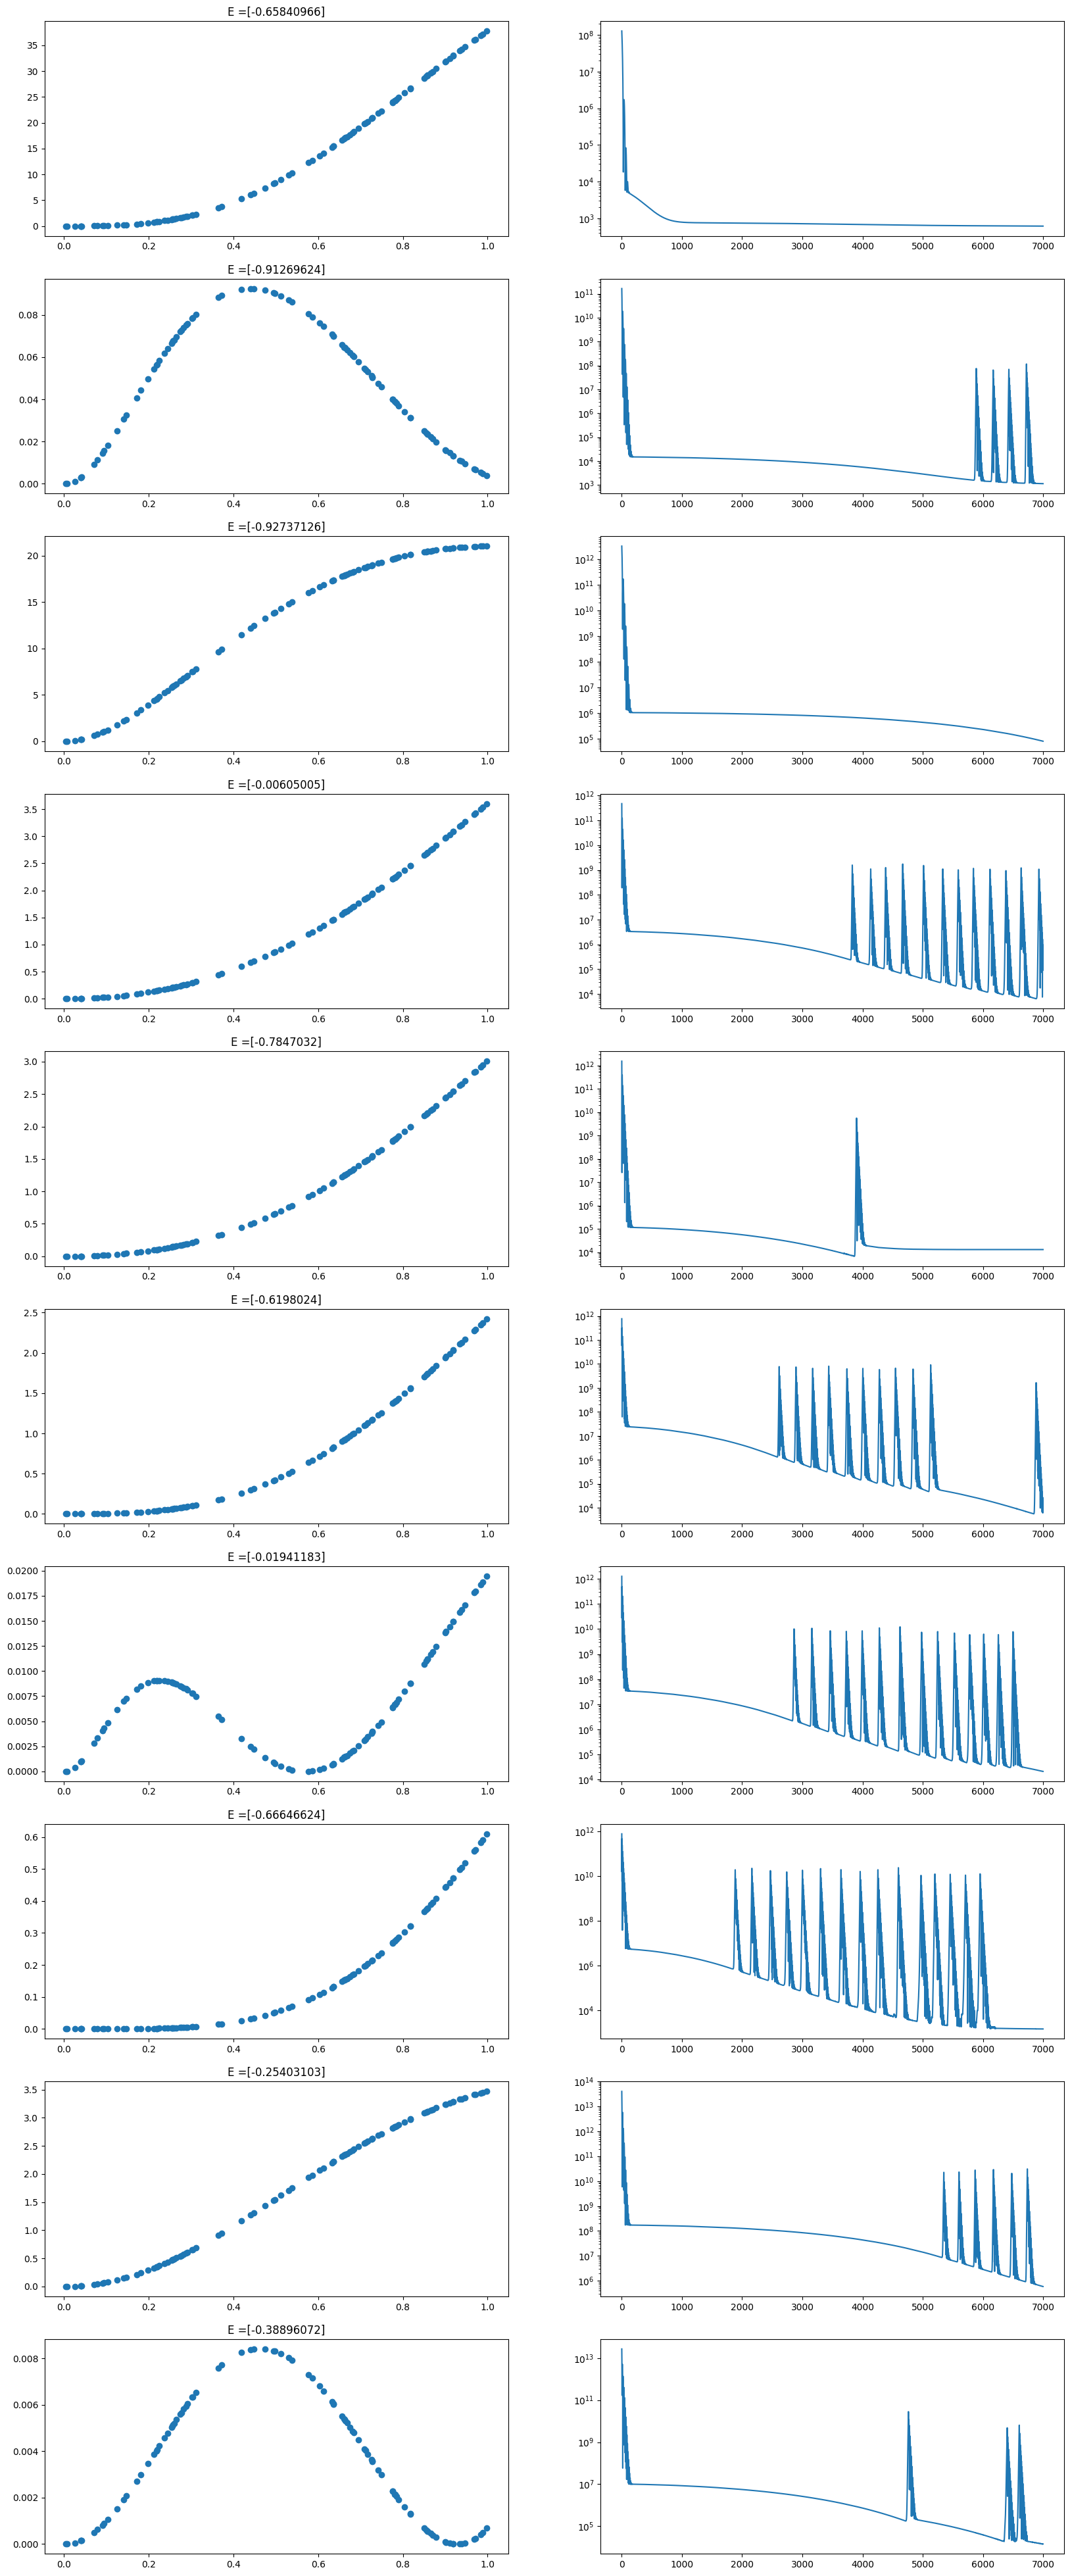

In [54]:
plt.figure(figsize=(20,M*5))

for i in range(M):
    plt.subplot(M,2,2*i+1)
    plt.title(f'E ={energias[i][0]}')
    plt.scatter(r_vals, soluciones[i]**2)
    plt.subplot(M,2,2+2*i)
    plt.yscale('log')
    plt.plot(range(epocs), loses[i])

plt.show()